In [16]:
import os 
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import sim functions
from neurodsp.sim import (sim_oscillation, sim_bursty_oscillation, sim_variable_oscillation, sim_damped_oscillation)
from neurodsp.utils import set_random_seed

from neurodsp.sim.combined import sim_combined, sim_peak_oscillation
from neurodsp.sim.aperiodic import sim_powerlaw

# Import function to compute power spectra
from neurodsp.spectral import compute_spectrum

# Import utilities for plotting data
from neurodsp.utils import create_times
from neurodsp.plts.spectral import plot_power_spectra
from neurodsp.plts.time_series import plot_time_series

In [17]:
# Set the random seed, for consistency simulating data
set_random_seed(0)

# Set some general settings, to be used across all simulations
fs = 2000
num_signals = 1000

# Simulation settings
n_seconds = 2
times = create_times(n_seconds, fs)

# Define the components of the combined signal to simulate
n_neurons_range = (800, 1200)  # range for number of neurons
firing_rate_range = (1, 5)     # range for firing rate
t_ker_range = (0.5, 1.5)       # range for t_ker
tau_r_range = (0.0005, 0.005)  # range for tau_r
tau_d_range = (0.010, 0.030)   # range for tau_d
freq_range = (15, 25)          # range for oscillation frequency
amplitude_range = (4, 7)   # range for amplitude_range

# Generate artifact
amplitude = np.random.uniform(amplitude_range[0], amplitude_range[1])
frequency = 130
period = 1 / frequency
num_cycles = int(np.ceil(times[-1] / period))
samples_per_period = int(fs * period) +1

# Sample values from the specified ranges
n_neurons = np.random.randint(n_neurons_range[0], n_neurons_range[1] + 1)
firing_rate = np.random.uniform(firing_rate_range[0], firing_rate_range[1])
t_ker = np.random.uniform(t_ker_range[0], t_ker_range[1])
tau_r = np.random.uniform(tau_r_range[0], tau_r_range[1])
tau_d = np.random.uniform(tau_d_range[0], tau_d_range[1])
freq = np.random.uniform(freq_range[0], freq_range[1])

# 초기 (0, 4000) 크기의 빈 numpy 배열 생성
set_shape_2d = np.zeros((0, len(times)))
# 초기 (1000, 4000) 크기의 빈 numpy 배열 생성
set_shape_2d_2 = np.zeros((num_signals, len(times)))
# 초기 (4000, ) 크기의 빈 numpy 배열 생성
set_shape_1d = np.zeros(len(times))

# -------- < original signal data > ------------------------------------------------

data_signal = set_shape_2d.copy()

# -------- < artifact data - type > ------------------------------------------------

data_sine = set_shape_2d.copy()
data_non_sine_v1 = set_shape_2d.copy()
data_non_sine_v2 = set_shape_2d.copy()

# -------- < artifact data - varying > ------------------------------------------------

data_varying = set_shape_2d_2.copy()

# -------- < synthesized data > ------------------------------------------------

data_with_non_sine_v2_varying = set_shape_2d.copy()

In [18]:
# ---------------------- << 생성 - data_signal >> ----------------------------------------------------------------------------------------------------------
for idx in range(num_signals):
   components = {
      'sim_synaptic_current': {
      'n_neurons': n_neurons,
      'firing_rate': firing_rate,
      't_ker': t_ker,
      'tau_r': tau_r,
      'tau_d': tau_d
      },
      'sim_oscillation': {
      'freq': freq
      }
   }
   # Simulate an oscillation over an aperiodic component
   signal = sim_combined(n_seconds, fs, components)

   data_signal = np.vstack((data_signal, signal))
   
print("data_sine shape:", data_signal.shape) # (1000, 4000)

data_sine shape: (1000, 4000)


Text(0.5, 1.0, 'data_signal')

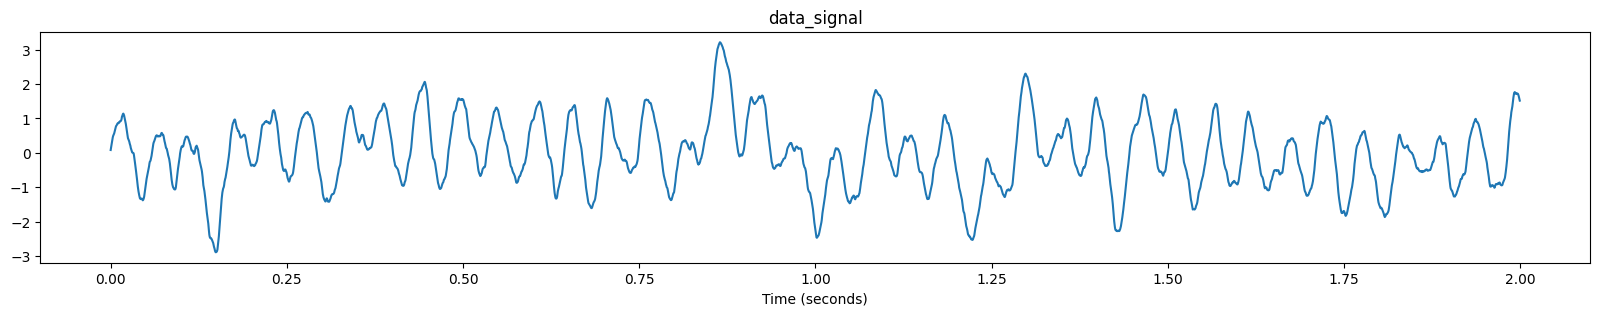

In [19]:
# 확대할 구간 설정
plt.figure(figsize=(20, 3))

plt.plot(times, data_signal[1, :], label = 'data signal')
plt.xlabel("Time (seconds)")
plt.title('data_signal')

In [20]:
# ------------------------------------<< sinusoidal oscillation >>------------------------------------------------------------------------------------------
# Simulate a sinusoidal oscillation
for idx in range(num_signals):
    # Generate a 130 Hz sine wave
    osc_sine = sim_oscillation(n_seconds, fs, frequency, cycle='sine')

    data_sine = np.vstack((data_sine, osc_sine))
    
print("data_sine shape:", data_sine.shape) # (1000, 4000)

# ------------------------------------<< non-sinusoidal oscillation >>------------------------------------------------------------------------------------------
# Define settings
rdsym = 0.2

# Simulate a non-sinusoidal oscillation
# osc_shape = sim_oscillation(n_seconds, fs, frequency, cycle='asine', rdsym=rdsym)

for idx in range(num_signals):
    # Generate a 130 Hz sine wave
    osc_shape = sim_oscillation(n_seconds, fs, frequency, cycle='asine', rdsym=rdsym)

    data_non_sine_v1 = np.vstack((data_non_sine_v1, osc_shape))
    
print("data_non_sine_v1 shape:", data_non_sine_v1.shape) # (1000, 4000)

data_sine shape: (1000, 4000)
data_non_sine_v1 shape: (1000, 4000)


In [21]:
# negative 영역 확장
neg_part = set_shape_1d.copy()
neg_parts = set_shape_2d.copy()

# positive 영역 유지
pos_part = set_shape_1d.copy()
pos_parts = set_shape_2d.copy()
neg_parts_hang = set_shape_2d_2.copy()

# negative/positive 영역 분리
for idx in range(num_signals):
    neg_part = np.where(data_non_sine_v1[idx, :] < 0, data_non_sine_v1[idx, :], 0)
    neg_parts = np.vstack((neg_parts, neg_part))

neg_parts = neg_parts * 2.5

for idx in range(num_signals):
    pos_part = np.where(data_non_sine_v1[idx, :] > 0, data_non_sine_v1[idx, :], 0)
    pos_parts = np.vstack((pos_parts, pos_part))

# data_non_sine_v2 생성
data_non_sine_v2 = pos_parts + neg_parts

print("data_non_sine_v2 shape:", data_non_sine_v2.shape) # (1000, 4000)

data_non_sine_v2 shape: (1000, 4000)


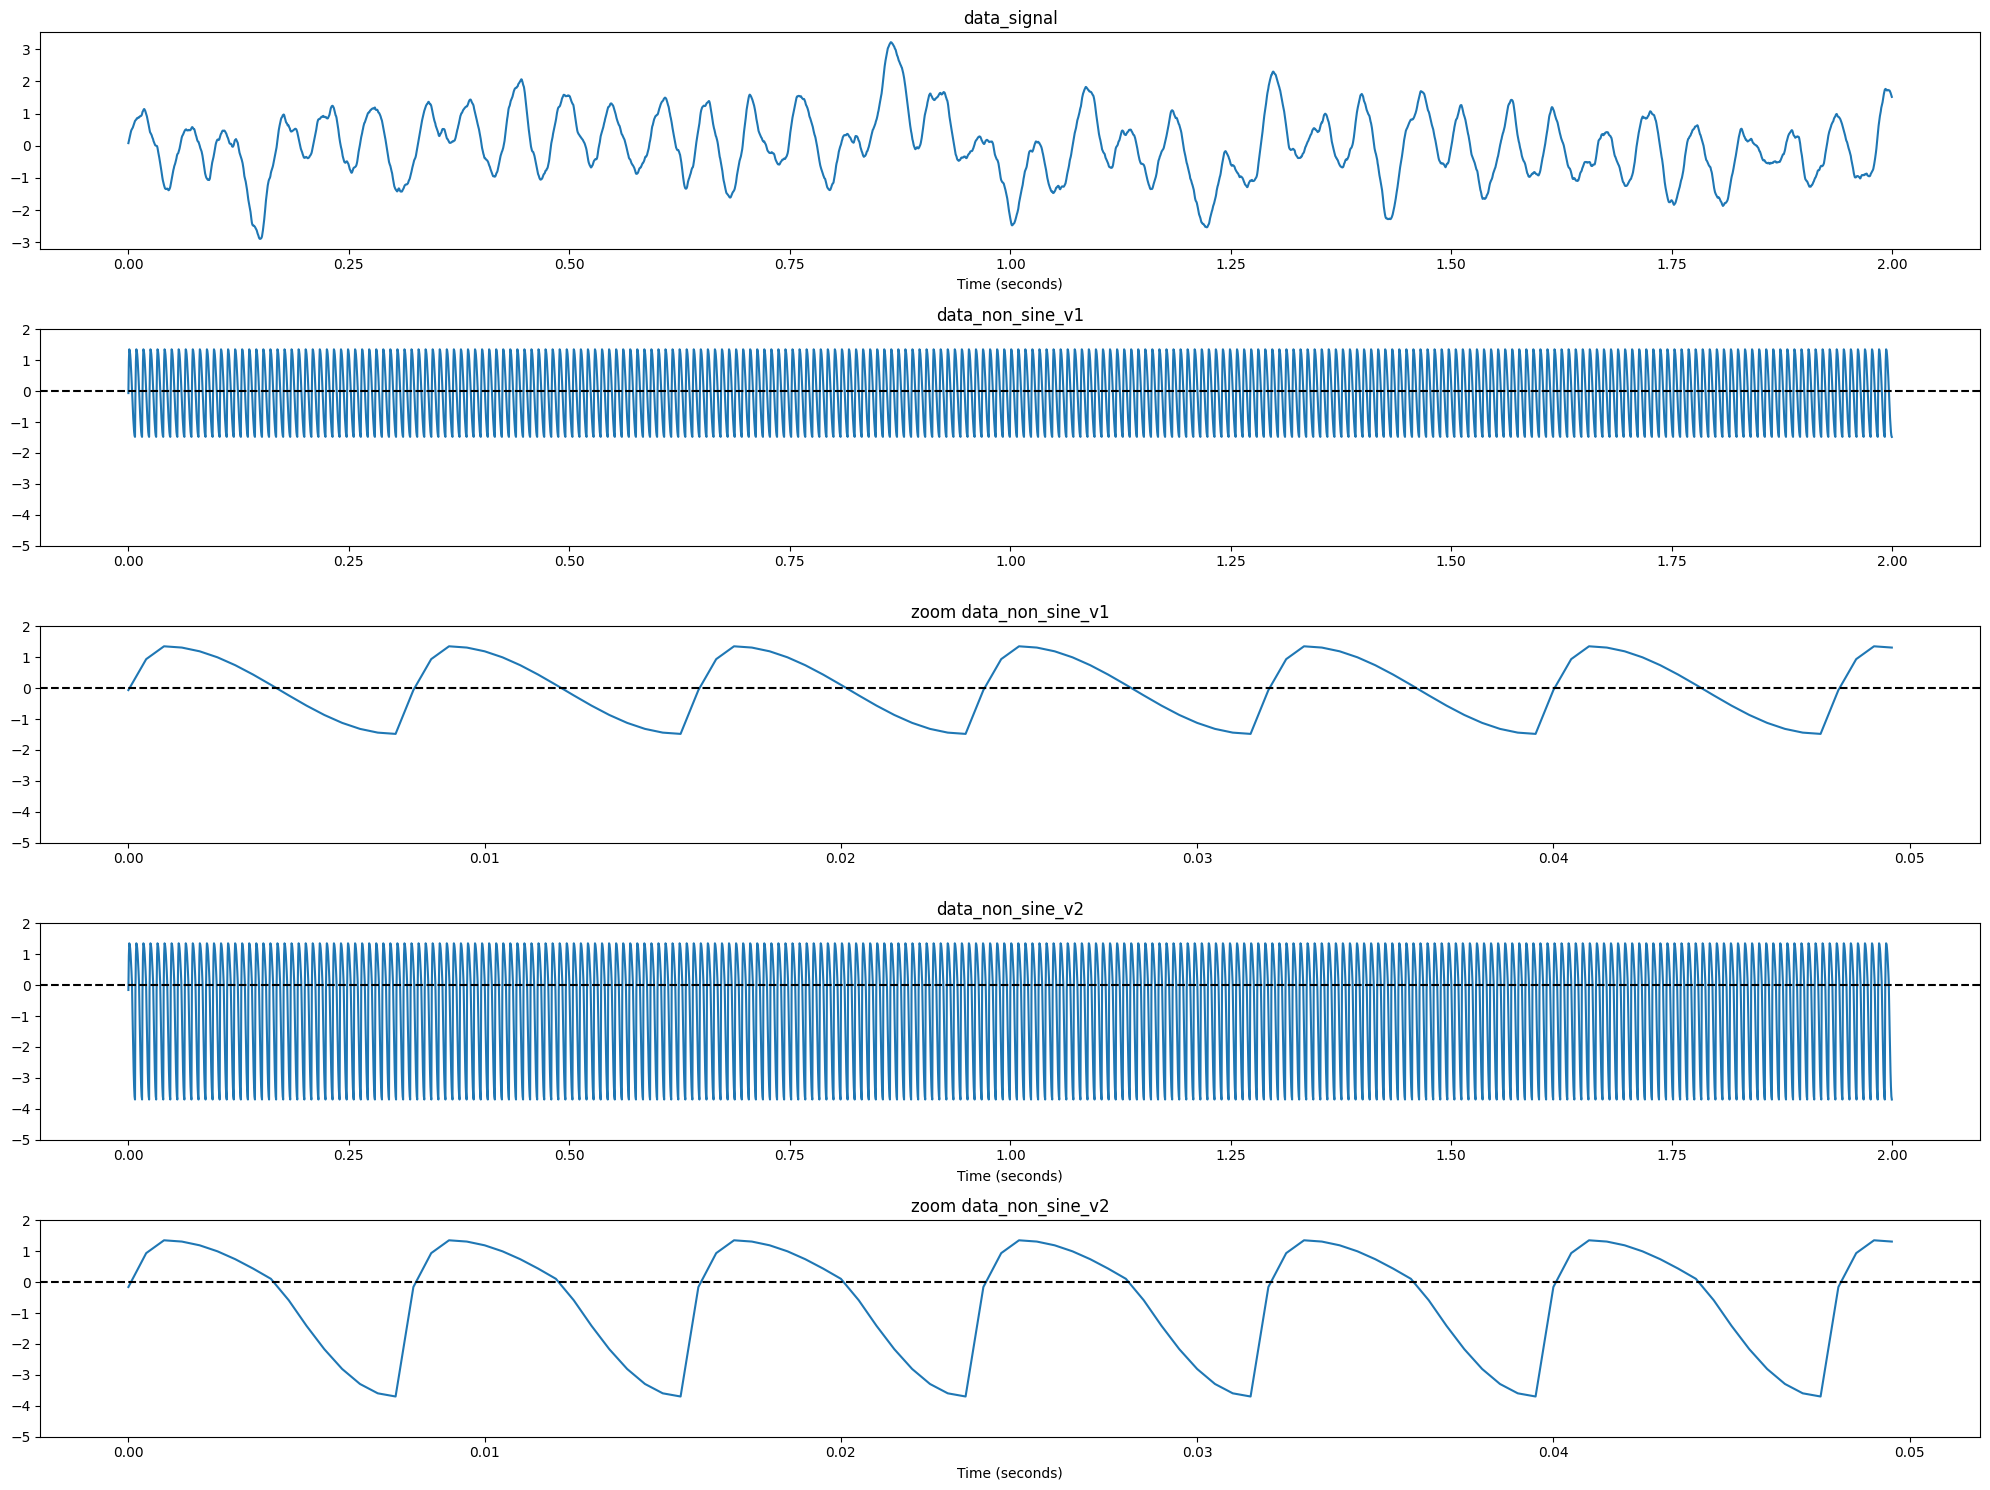

In [22]:
plt.figure(figsize=(20, 15))

plt.subplot(5, 1, 1)
plt.plot(times, data_signal[1, :])
plt.xlabel("Time (seconds)")
plt.title('data_signal')

plt.subplot(5, 1, 2)
plt.plot(times, data_non_sine_v1[1, :]); plt.gca().set_ylim([-5, 2])
plt.axhline(y=0, color='k', linestyle='--')
plt.title('data_non_sine_v1')

plt.subplot(5, 1, 3)
plt.plot(times[0:100], data_non_sine_v1[1, 0:100]); plt.gca().set_ylim([-5, 2])
plt.axhline(y=0, color='k', linestyle='--')
plt.title('zoom data_non_sine_v1')

plt.subplot(5, 1, 4)
plt.plot(times, data_non_sine_v2[1, :]); plt.gca().set_ylim([-5, 2])
plt.axhline(y=0, color='k', linestyle='--')
plt.xlabel("Time (seconds)")
plt.title('data_non_sine_v2')

plt.subplot(5, 1, 5)
plt.plot(times[0:100], data_non_sine_v2[1, 0:100]); plt.gca().set_ylim([-5, 2])
plt.axhline(y=0, color='k', linestyle='--')
plt.xlabel("Time (seconds)")
plt.title('zoom data_non_sine_v2')

plt.tight_layout()

In [23]:
# Varying 추가
# random_amplitudes = np.random.uniform(amplitude_range_mean * 5, amplitude_range_mean * 10, num_signals)
random_amplitudes = np.random.uniform(0.75, 1.25, (num_signals, num_cycles))

for idx in range(num_signals):
    for i in range(num_cycles):
        start_idx = i * samples_per_period
        end_idx = min((i + 1) * samples_per_period, len(times))

        if start_idx >= len(times):
            break

        each_period = set_shape_1d.copy()
        each_period[start_idx:end_idx] = random_amplitudes[idx, i] * data_non_sine_v2[idx, start_idx:end_idx]
        data_varying[idx, start_idx:end_idx] += each_period[start_idx:end_idx]
    

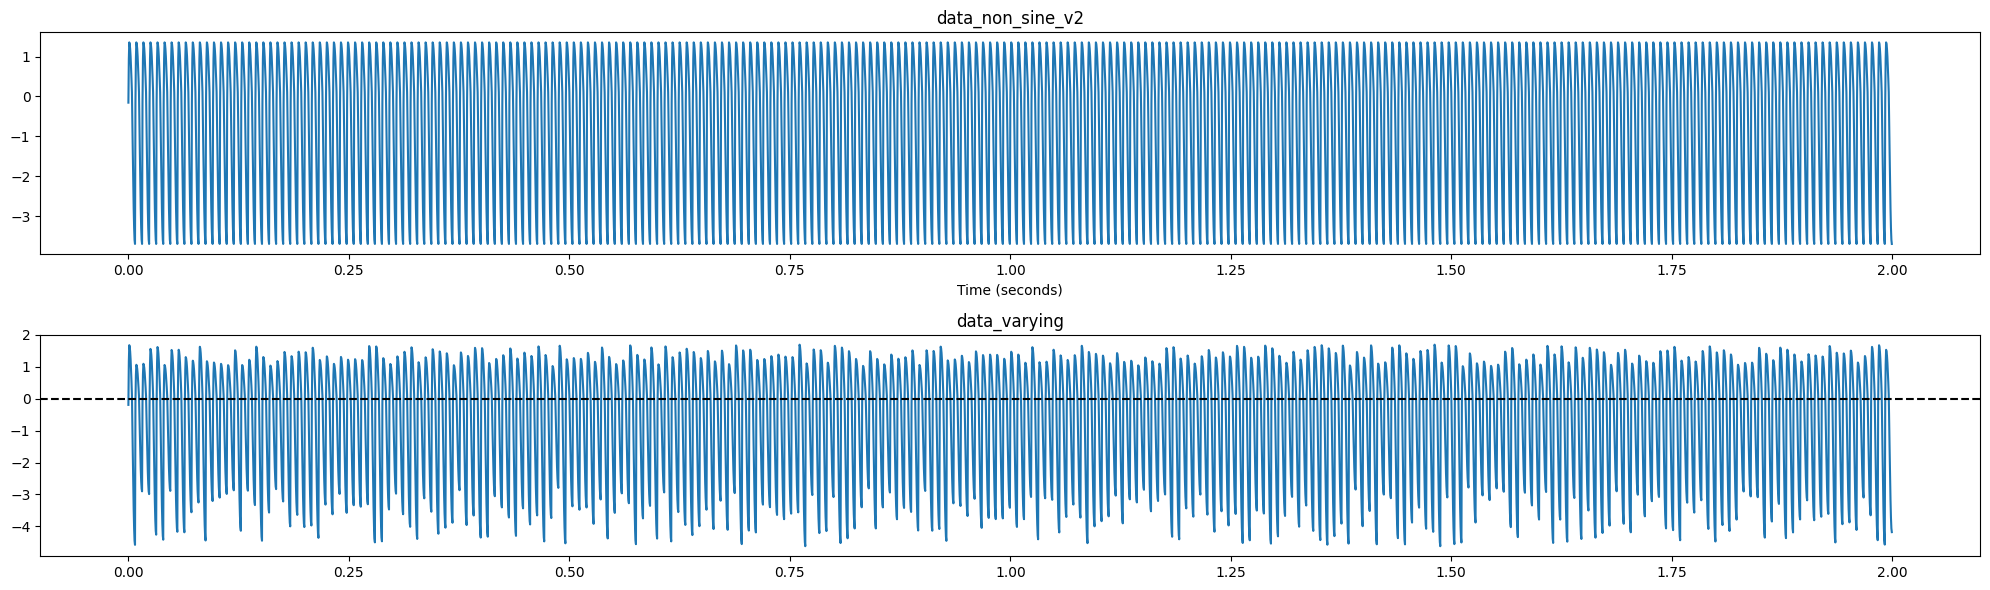

In [24]:
plt.figure(figsize=(20, 6))

plt.subplot(2, 1, 1)
plt.plot(times, data_non_sine_v2[1, :])
plt.xlabel("Time (seconds)")
plt.title('data_non_sine_v2')

plt.subplot(2, 1, 2)
plt.plot(times, data_varying[1, :])
plt.axhline(y=0, color='k', linestyle='--')
plt.title('data_varying')

plt.tight_layout()

# print(np.count_nonzero(data_varying[1, :] == 0)) # 100
# print(samples_per_period) # 15
# print(num_cycles) # 260 
# 260 * 15 = 3900

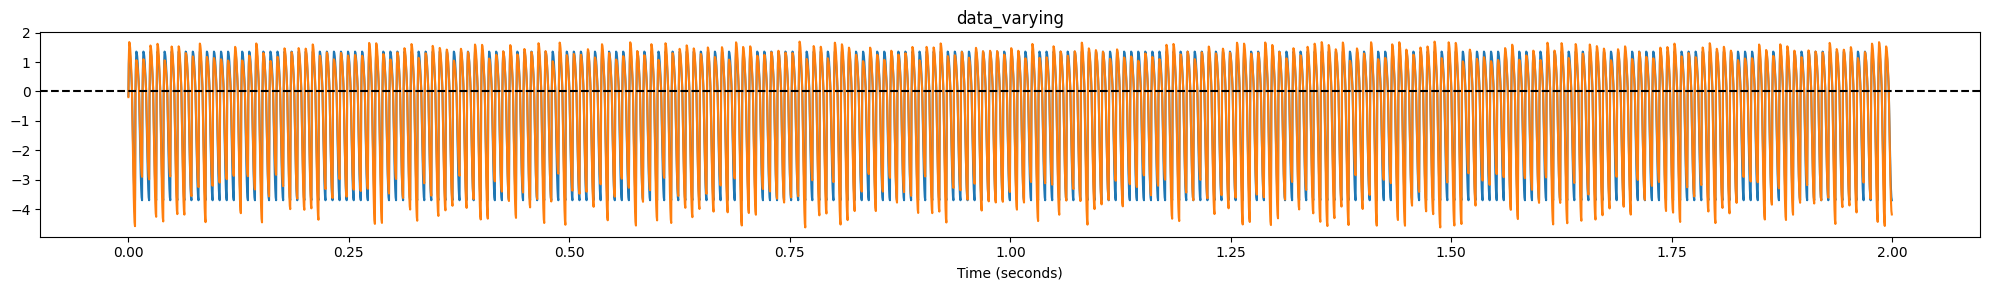

In [25]:
plt.figure(figsize=(20, 3))

plt.plot(times, data_non_sine_v2[1, :])
plt.xlabel("Time (seconds)")
plt.plot(times, data_varying[1, :])
plt.axhline(y=0, color='k', linestyle='--')
plt.title('data_varying')

plt.tight_layout()

data_varying shape: (1000, 4000)


<Figure size 2000x300 with 0 Axes>

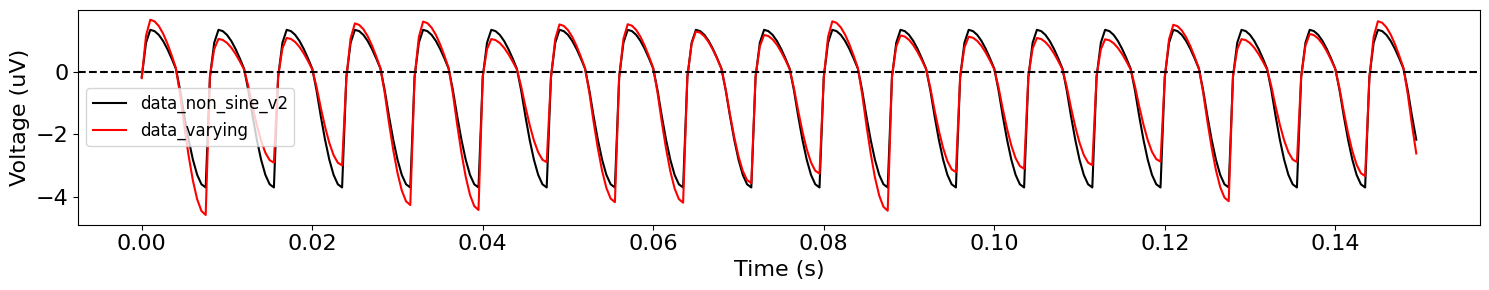

In [26]:
plt.figure(figsize=(20, 3))
plot_time_series(times[0:300], [data_non_sine_v2[1, 0:300], data_varying[1, 0:300]], labels=['data_non_sine_v2', 'data_varying'], colors=['k', 'r'])
plt.axhline(y=0, color='k', linestyle='--')

print('data_varying shape:', data_varying.shape)

data_with_non_sine_v2_varying shape: (1000, 4000)


<Figure size 2000x300 with 0 Axes>

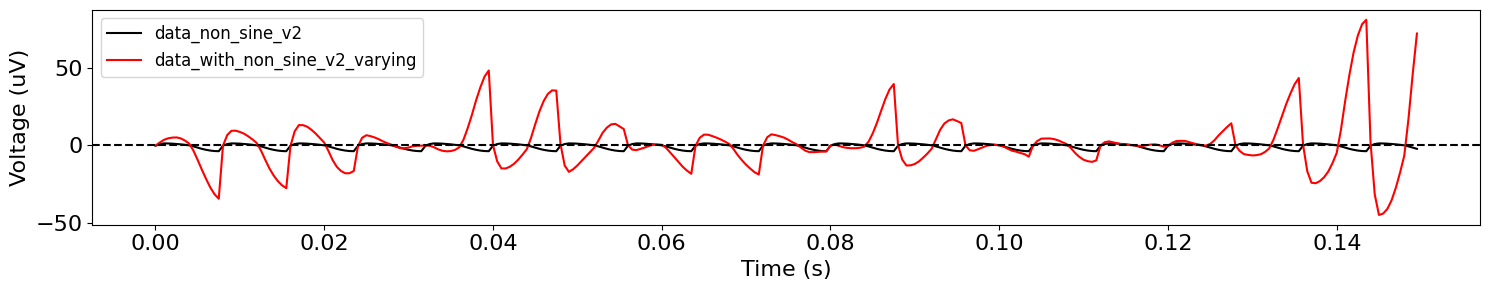

In [27]:
data_with_non_sine_v2_varying = data_signal + data_varying * data_signal.copy() * 10

plt.figure(figsize=(20, 3))
plot_time_series(times[0:300], [data_non_sine_v2[1, 0:300], data_with_non_sine_v2_varying[1, 0:300]], 
                 labels=['data_non_sine_v2', 'data_with_non_sine_v2_varying'], colors=['k', 'r'])
plt.axhline(y=0, color='k', linestyle='--')

print('data_with_non_sine_v2_varying shape:', data_with_non_sine_v2_varying.shape)

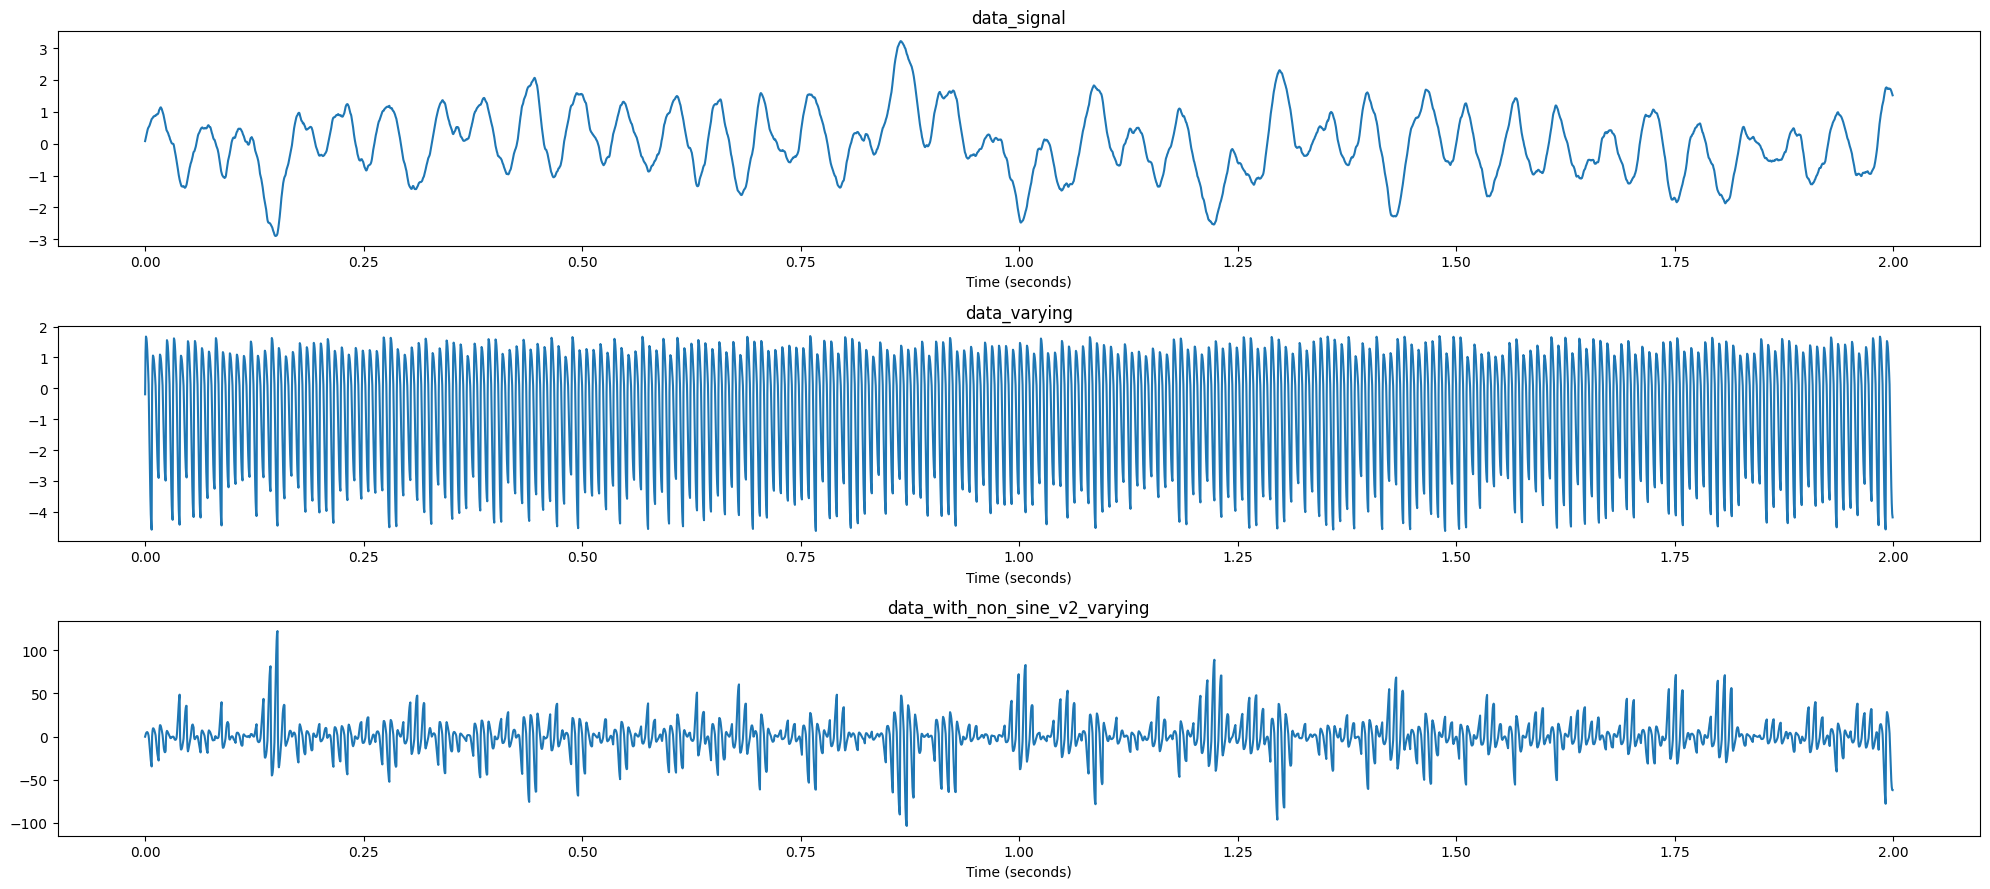

In [28]:
# 전체 플랏
plt.figure(figsize=(20, 9))

plt.subplot(3, 1, 1)
plt.plot(times, data_signal[1, :])
plt.xlabel("Time (seconds)")
plt.title('data_signal')

plt.subplot(3, 1, 2)
plt.plot(times, data_varying[1, :])
plt.xlabel("Time (seconds)")
plt.title('data_varying')

plt.subplot(3, 1, 3)
plt.plot(times, data_with_non_sine_v2_varying[1, :])
plt.xlabel("Time (seconds)")
plt.title('data_with_non_sine_v2_varying')

plt.tight_layout()

In [29]:
# -------- < 저장 > ------------------------------------------------

fpath = "../data/DNN_data/v3/"

# -------- < original signal data > ------------------------------------------------

np.save(fpath + "data_signal" + ".npy", data_signal)

# -------- < synthesized data > ------------------------------------------------

np.save(fpath + "data_with_non_sine_v2_varying" + ".npy", data_with_non_sine_v2_varying)
